SVM / SVC
SVC - klasyfikator oparty na maszynie wektorów nośnych (support vector machine)
image.png 

In [ ]:
import pandas as pd
import numpy as np


from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier

from time import time
import scipy.stats as stats
from sklearn.utils.fixes import loguniform
from scipy.stats import uniform
import matplotlib.pyplot as plt

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

import xgboost as xgb

In [ ]:
raw_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/Train_raw.csv')
raw_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/Test_raw.csv')

Adasyn_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/Adasyn_train.csv')
Adasyn_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/Adasyn_test.csv')

Nearmiss_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/Nearmiss_train.csv')
Nearmiss_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/Nearmiss_test.csv')

ROS_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/ROS_train.csv')
ROS_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/ROS_test.csv')

RUS_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/RUS_train.csv')
RUS_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/RUS_test.csv')

SMOTETomek_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/SMOTETomek_train.csv')
SMOTETomek_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/SMOTETomek_test.csv')

In [ ]:
pip install neptune-client

In [ ]:
import neptune

API_TOKEN='' #@param {type:"string"}

PROJEKT_NAME = 'DataWorkshop-Foundation/Predicting-cancellation-of-visit' 

neptune.init(
   api_token=API_TOKEN,
   project_qualified_name=PROJEKT_NAME
)

Project(DataWorkshop-Foundation/Predicting-cancellation-of-visit)

In [ ]:
raw_train.head()

,PatientId,Gender,Age,Neighbourhood_0,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,MonthBookingDate_0,MonthBookingDate_1,MonthBookingDate_2,MonthBookingDate_3,DayBookingDate_0,DayBookingDate_1,DayBookingDate_2,DayBookingDate_3,DayBookingDate_4,DayBookingDate_5,MonthAppointmentDate_0,MonthAppointmentDate_1,MonthAppointmentDate_2,DayAppointmentDate_0,DayAppointmentDate_1,DayAppointmentDate_2,DayAppointmentDate_3,DayAppointmentDate_4,DayAppointmentDate_5,HourOfDayBooking_0,DaysToAppointment,AppointmentWeekDay_0,AppointmentWeekDay_1,AppointmentWeekDay_2,AppointmentWeekDay_3,NoShow
0,4652519881919,0,8,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,1,1,1,0,1,0,1,0,0,0,0,0,1,0,1,1,0,0,1,0,0
1,81431485833737,0,74,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,1,12,0,0,1,1,0
2,555956674526286,0,50,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,31,0,0,0,1,0
3,14559326134688,0,21,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,1,5,0,0,1,0,0
4,16796474433112,0,39,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,1,1,1,1,1,0,1,0,0,1,0,0,0,0,1,4,0,0,0,1,1


In [ ]:
def get_feats(df):
    feats = df.select_dtypes(include=[np.int, np.float]).columns 
    return feats[ (feats != 'NoShow')].values

def get_X(df):
    return df[ get_feats(df) ].values

def get_y(df, target_var='NoShow'):
    return df[target_var].values

In [ ]:
feats = ['PatientId',
 	'Gender',
  'Age', 	
  'Neighbourhood_0', 	
  'Neighbourhood_1', 	
  'Neighbourhood_2', 	
  'Neighbourhood_3',	
  'Neighbourhood_4', 	
  'Neighbourhood_5', 
  'Neighbourhood_6', 
  'Neighbourhood_7',	
  'Scholarship', 	
  'Hypertension', 	
  'Diabetes', 	
  'Alcoholism', 	
  'Handicap', 	
  'SMSReceived', 	
  'MonthBookingDate_0', 	
  'MonthBookingDate_1',	
  'MonthBookingDate_2', 	
  'MonthBookingDate_3', 	
  'DayBookingDate_0', 	
  'DayBookingDate_1',	
  'DayBookingDate_2',	
  'DayBookingDate_3', 	
  'DayBookingDate_4', 	
  'DayBookingDate_5', 	
  'MonthAppointmentDate_0', 	
  'MonthAppointmentDate_1', 	
  'MonthAppointmentDate_2', 	
  'DayAppointmentDate_0',	
  'DayAppointmentDate_1',	
  'DayAppointmentDate_2',	
  'DayAppointmentDate_3', 	
  'DayAppointmentDate_4',
  'DayAppointmentDate_5', 	
  'HourOfDayBooking_0', 	
  'DaysToAppointment', 	
  'AppointmentWeekDay_0', 	
  'AppointmentWeekDay_1', 	
  'AppointmentWeekDay_2', 	
  'AppointmentWeekDay_3']

In [ ]:
X_raw = get_X(raw_train)
y_raw = get_y(raw_train)

In [ ]:
def model(train, test, search, name, tags):
  
  #print(search.get_params())
  y_train = train["NoShow"]
  y_test = test["NoShow"]

  X_train = train.loc[:, train.columns != 'NoShow']
  X_test = test.loc[:, test.columns != 'NoShow']
  print(search)              
  search = search.fit(X_train, y_train)
  
  #search.best_params_

  y_pred = search.predict(X_test)
  print(y_pred)
  accuracy = accuracy_score(y_test, y_pred)
  print("Accuracy: %.2f%%" % (accuracy * 100.0))
  print(' f1 ', f1_score(y_test, y_pred), '\n',
        'recall', recall_score(y_test, y_pred), '\n',
        'precision', precision_score(y_test, y_pred) )

  neptune.create_experiment(
      name=name
  )

  neptune.log_metric('accuracy', accuracy)
  neptune.log_metric('f1', f1_score(y_test, y_pred))
  neptune.log_metric('recall', recall_score(y_test, y_pred))
  neptune.log_metric('precision', precision_score(y_test, y_pred))
  neptune.append_tags(tags)
  #neptune.append_tags([str(best),"Magdalena Cebula"])
  neptune.append_tags([str(feats)])
  #neptune.append_tags([str(space4dt)])
  from sklearn.metrics import confusion_matrix

  conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
  print('Confusion matrix:\n', conf_mat)

  from matplotlib import pyplot as plt

  labels = ['Class 0', 'Class 1']
  fig = plt.figure()
  ax = fig.add_subplot()
  cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
  fig.colorbar(cax)
  ax.set_xticklabels([''] + labels)
  ax.set_yticklabels([''] + labels)
  plt.xlabel('Predicted')
  plt.ylabel('Expected')
  plt.show()

  neptune.log_image('Confusion_matrix ' + name, fig)
  
  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, search.predict(X_test))
  print(false_positive_rate, true_positive_rate, thresholds)


  roc_auc_score(y_test, y_pred)
  auc = roc_auc_score(y_test, y_pred)
  neptune.log_metric('roc_auc', auc)
  fig = plt.figure()
  plt.plot(false_positive_rate,true_positive_rate,label="data 1, auc="+str(auc))
  plt.legend(loc=4)
  plt.show()
  neptune.log_image('ROC AUC ' + name, fig)
  neptune.stop()

In [ ]:
from sklearn.svm import SVC

In [ ]:
svc = SVC(verbose = True)
print(svc)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=True)


[0 0 0 ... 0 0 0]
Accuracy: 79.81%
 f1  0.0 
 recall 0.0 
 precision 0.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-283


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix:
 [[61921     0]
 [15664     0]]


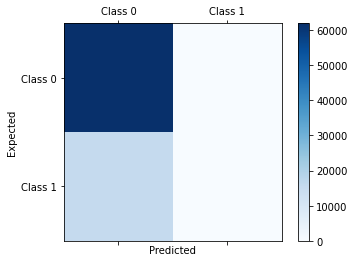

[0. 1.] [0. 1.] [1 0]


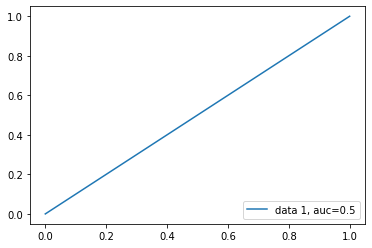

In [ ]:
model(raw_train, raw_train,SVC(),'SVC', ['SVC', 'Raw'])

In [ ]:
X_neamiss = get_X(Nearmiss_train)
y_neamiss = get_y(Nearmiss_train)

In [ ]:
parameter_space_svc = {
   'C':hp.loguniform("C", np.log(1), np.log(100)),
   'kernel':hp.choice('kernel',['rbf','poly']),
   'gamma': hp.loguniform("gamma", np.log(0.001), np.log(0.1)),    
}

In [ ]:
from functools import partial

In [ ]:
def run_model(model, x, y):

  scores = cross_val_score(model, x, y, cv = 3, scoring='f1')
  
  return np.mean(scores), np.std(scores)

def hyperopt_train_test(params, x, y):
 

  print("Training with params: ")
  print(params)
  clf = SVC(**params)
  mean_f1, score_std = run_model(clf, x, y)
  print('loss: ',np.abs(mean_f1))
  return np.abs(mean_f1)

count = 0
best = 0

def f(params):
  f1 = hyperopt_train_test(params, X_neamiss, y_neamiss)
  return {'loss': -f1, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, parameter_space_svc, algo=partial(tpe.suggest, n_startup_jobs=1), max_evals=25, trials=trials)
print('best:')
print(best)

Training with params: 
{'C': 1.5826269617119755, 'gamma': 0.032264725642952886, 'kernel': 'poly'}
loss: 
0.6666666657610292
Training with params: 
{'C': 1.214093111599506, 'gamma': 0.06488785703511375, 'kernel': 'poly'}
loss: 
0.6666666657610292
Training with params: 
{'C': 31.375610125595426, 'gamma': 0.0019583531523533772, 'kernel': 'rbf'}
loss: 
0.6217231518054359
Training with params: 
{'C': 1.4882492808553265, 'gamma': 0.08648374394124571, 'kernel': 'poly'}
loss: 
0.6666666657610292
Training with params: 
{'C': 5.4512096047123455, 'gamma': 0.012201249333051877, 'kernel': 'poly'}
loss: 
0.6666666657610292
Training with params: 
{'C': 84.19461380540118, 'gamma': 0.012257418795398397, 'kernel': 'poly'}
loss: 
0.6666666657610292
Training with params: 
{'C': 4.862655174278486, 'gamma': 0.0010793906985729932, 'kernel': 'rbf'}
loss: 
0.6174570630143759
Training with params: 
{'C': 16.06364170767721, 'gamma': 0.034952230676655344, 'kernel': 'poly'}
loss: 
0.6666666657610292
Training with 

In [ ]:
best

{'C': 1.5826269617119755, 'gamma': 0.032264725642952886, 'kernel': 1}

In [ ]:
def getKernel():
  if best['kernel'] == 0:
    best['kernel'] = 'rbf'
  else:
    best['kernel'] = 'poly'

In [ ]:
getKernel()

In [ ]:
clf =  SVC(**best)

In [ ]:
clf

SVC(C=1.5826269617119755, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma=0.032264725642952886, kernel='poly', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)

SVC(C=1.5826269617119755, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma=0.032264725642952886, kernel='poly', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)
[1 1 1 ... 1 1 1]
Accuracy: 50.00%
 f1  0.6666666666666666 
 recall 1.0 
 precision 0.5
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-284
Confusion matrix:
 [[   0 4418]
 [   0 4418]]


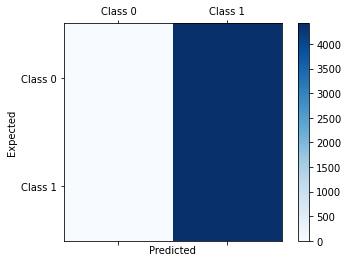

[0. 1.] [0. 1.] [2 1]


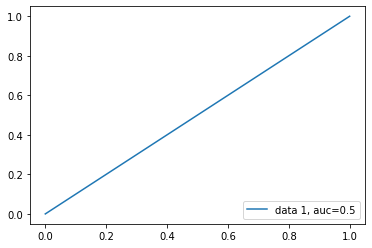

In [ ]:
model(Nearmiss_train, Nearmiss_test, clf, 'SVC', ['SVC', 'Nearmiss'])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
[1 1 1 ... 0 1 1]
Accuracy: 50.03%
 f1  0.61416034837198 
 recall 0.7954194102490696 
 precision 0.5001800244833298
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-285
Confusion matrix:
 [[ 3583 13882]
 [ 3573 13892]]


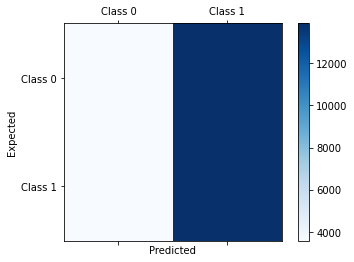

[0.         0.79484684 1.        ] [0.         0.79541941 1.        ] [2 1 0]


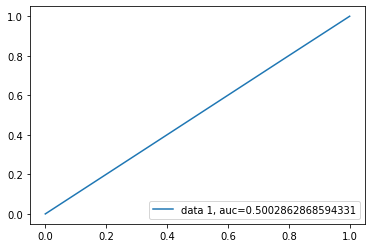

In [ ]:
model(ROS_train, ROS_test,SVC(), 'SVC', ['SVC', 'ROS'])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=True)
[LibSVM][1 1 1 ... 1 1 1]
Accuracy: 49.63%
 f1  0.6319966928482844 
 recall 0.8650973291081937 
 precision 0.4978507229386479
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-286
Confusion matrix:
 [[ 563 3855]
 [ 596 3822]]


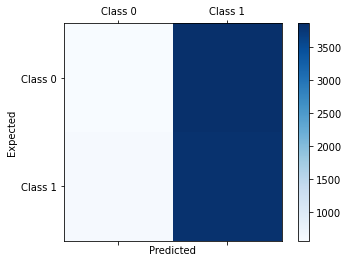

[0.         0.87256677 1.        ] [0.         0.86509733 1.        ] [2 1 0]


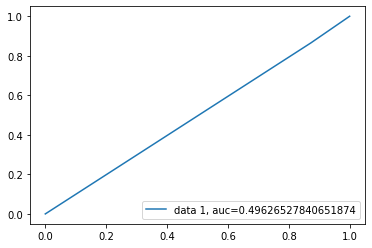

In [ ]:
model(RUS_train, RUS_test,SVC(verbose = True), 'SVC', ['SVC', 'RUS'])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=True)
[LibSVM][0 0 0 ... 0 0 0]
Accuracy: 49.86%
 f1  0.4135335092804915 
 recall 0.35358094110683636 
 precision 0.49796811503594873
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-287
Confusion matrix:
 [[8698 4818]
 [8737 4779]]


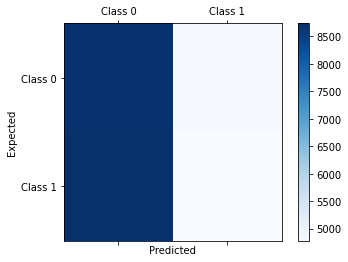

[0.         0.35646641 1.        ] [0.         0.35358094 1.        ] [2 1 0]


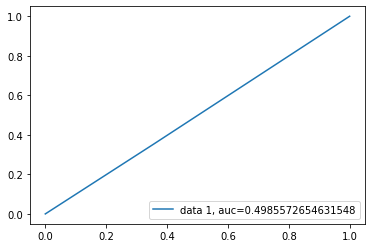

In [ ]:
model(SMOTETomek_train, SMOTETomek_test,SVC(verbose = True), 'SVC', ['SVC', 'SMOTETomek'])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=True)
[LibSVM][0 0 0 ... 0 0 0]
Accuracy: 49.81%
 f1  0.3374395405078597 
 recall 0.2555517399267399 
 precision 0.4965524911032028
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-288
Confusion matrix:
 [[12938  4527]
 [13007  4465]]


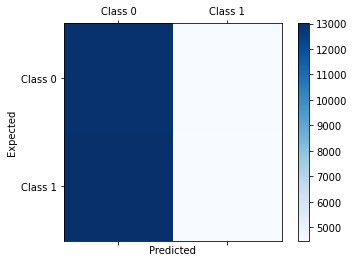

[0.         0.25920412 1.        ] [0.         0.25555174 1.        ] [2 1 0]


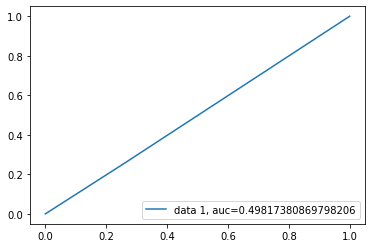

In [ ]:
model(Adasyn_train, Adasyn_test,SVC(verbose = True), 'SVC', ['SVC', 'Adasyn'])

Literatura:
Marcin Szeliga, Data Science i uczenie maszynowe

